In [3]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import contractions
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

In [4]:
df1 = pd.read_csv('data/csv/us_election_2020_1st_presidential_debate.csv')
df2 = pd.read_csv('data/csv/us_election_2020_2nd_presidential_debate.csv')

In [5]:
df1.head()

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.


In [6]:
df2.head()

,speaker,minute,text
0,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo..."
1,Donald Trump,07:37,How are you doing? How are you?
2,Kristen Welker,07:58,And I do want to say a very good evening to bo...
3,Kristen Welker,08:27,The goal is for you to hear each other and for...
4,Kristen Welker,09:03,… during this next stage of the coronavirus cr...


In [7]:
df1.info()
print('\n')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  789 non-null    object
 1   minute   788 non-null    object
 2   text     789 non-null    object
dtypes: object(3)
memory usage: 18.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  512 non-null    object
 1   minute   512 non-null    object
 2   text     512 non-null    object
dtypes: object(3)
memory usage: 12.1+ KB


In [8]:
df1.describe().transpose()

,count,unique,top,freq
speaker,789,4,President Donald J. Trump,314
minute,788,658,20:57,5
text,789,756,That is not true.,5


In [9]:
df2.describe().transpose()

,count,unique,top,freq
speaker,512,3,Donald Trump,190
minute,512,400,11:03,5
text,512,489,Okay.,7


In [10]:
df1.speaker.value_counts()

President Donald J. Trump    314
Vice President Joe Biden     249
Chris Wallace                225
Chris Wallace:                 1
Name: speaker, dtype: int64

In [11]:
# We can see that in the first file, 'Chris Wallace' is also represented as 'Chris Wallace:'

In [12]:
df2.speaker.value_counts()

Donald Trump      190
Kristen Welker    189
Joe Biden         133
Name: speaker, dtype: int64

In [13]:
df1.isnull().any()

speaker    False
minute      True
text       False
dtype: bool

In [14]:
df2.isnull().any()

speaker    False
minute     False
text       False
dtype: bool

In [15]:
# Upon inspection of the null value in df['minute'] we can see that there is a new segment starting and so the timer is reset. So we can set the null value as 00:00

In [16]:
df1['minute'].fillna('00:00', inplace=True)

In [17]:
# Changing 'Chris Wallace:' to 'Chris Wallace'

In [18]:
df1.loc[df1['speaker'] == 'Chris Wallace:','speaker'] = 'Chris Wallace'

In [19]:
df1.loc[df1['speaker'] == 'President Donald J. Trump','speaker'] = 'Donald Trump'

In [20]:
df1.loc[df1['speaker'] == 'Vice President Joe Biden','speaker'] = 'Joe Biden'

In [21]:
df1.speaker.value_counts()

Donald Trump     314
Joe Biden        249
Chris Wallace    226
Name: speaker, dtype: int64

In [22]:
def conv_min_2_sec(x):
    # Function to convert df['minute'] column which represents the minute at which the candidate starts speaking to df['seconds'] 
    temp = list(map(int, x.split(':')))
    total=0
    if len(temp)==2:
        total = (temp[0]*60)+temp[1]
    elif len(temp)==3:
        total = (temp[0]*3600)+(temp[1]*60)+temp[2]
    return total

In [23]:
def calc_diff(dff):
    # Function to convert df['seconds'] to df['seconds_spoken'] which represents seconds spoken. 
    dff['seconds'] = dff['minute'].apply(conv_min_2_sec)
    dff['seconds_spoken'] = dff['seconds'] - dff['seconds'].shift(-1)
    dff['seconds_spoken'].fillna(0, inplace=True)
    dff['seconds_spoken'] = abs(dff['seconds_spoken'])
    return dff

In [24]:
def correct_seconds_spoken(dff):
    # Function to set df['seconds_spoken'] to 0 when there is a change in segment. 
    l = dff.index[dff['minute']=='00:00'].tolist()
    l = [n - 1 for n in l]
    for i in range(0,len(l)):
        dff.loc[l[i],'seconds_spoken']=0

In [25]:
calc_diff(df1)
correct_seconds_spoken(df1)
calc_diff(df2)
correct_seconds_spoken(df2)
print('\n')

In [26]:
df1.drop(['seconds','minute'],axis=1,inplace=True)
df2.drop(['seconds','minute'],axis=1,inplace=True)

In [27]:
frames = [df1, df2]
df = pd.concat(frames)

In [28]:
df.head()

,speaker,text,seconds_spoken
0,Chris Wallace,Good evening from the Health Education Campus ...,50.0
1,Chris Wallace,This debate is being conducted under health an...,39.0
2,Joe Biden,"How you doing, man?",2.0
3,Donald Trump,How are you doing?,0.0
4,Joe Biden,I’m well.,20.0


In [29]:
df.shape

(1301, 3)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 511
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker         1301 non-null   object 
 1   text            1301 non-null   object 
 2   seconds_spoken  1301 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.7+ KB


In [31]:
df_master = df.copy()

In [32]:
df_candidate=df[(df['speaker']!='Chris Wallace') & (df['speaker']!='Kristen Welker')] # df that consists of sentences by Donald Trump and Joe Biden only.

In [33]:
df_candidate.shape

(886, 3)

In [34]:
df_candidate.reset_index(inplace=True, drop=True)

# Vocabulary size

In [1]:
def calc_vocab(d,s):
    t = 0
    a = ' '.join(d[d['speaker']==s]['text'])
    a = a.split()
    a = set(a)
    return len(a)

In [ ]:
print('Donald Trump' + '\t' + str(calc_vocab(df,'Donald Trump')))
print('Joe Biden' + '\t' + str(calc_vocab(df,'Joe Biden')))

# Longest speaking time

In [35]:
max_sec = df_candidate['seconds_spoken'].idxmax()

In [41]:
print('Longest speaking time:\n')
print('Speaker: '  + df_candidate.loc[max_sec,'speaker'] +'\n')
print('Seconds Spoken: ' + str(df_candidate.loc[max_sec,'seconds_spoken'])+'\n')
print('Text: ' + df_candidate.loc[max_sec,'text'])

## Longest speaking time:


### Speaker: Joe Biden


### Seconds Spoken: 68.0


Text: Gas and oil because the heat will not be going out. There’s so many things that we can do now to create thousands and thousands of jobs. We can get to net zero, in terms of energy production, by 2035. Not only not costing people jobs, creating jobs, creating millions of good-paying jobs. Not 15 bucks an hour, but prevailing wage, by having a new infrastructure that in fact, is green. And the first thing I will do, I will rejoin the Paris Accord. I will join the Paris Accord because with us out of it, look what’s happening. It’s all falling apart. And talk about someone who has no relationship with foreign policy. The rainforests of Brazil are being torn down, are being ripped down. More carbon is absorbed in that rainforest than every bit of carbon that’s emitted in the United States. Instead of doing something about that, I would be gathering up and making sure we had the countries of the world coming up with $20 billion, and say, “Here’s $20 billion. Stop tearing down the fores

# Total time spoken

In [56]:
total_sec_spoken = df.groupby('speaker',as_index=False).agg('sum').sort_values(by='seconds_spoken',ascending=False)

In [57]:
total_sec_spoken['time'] = [str(datetime.timedelta(seconds=x)) for x in total_sec_spoken['seconds_spoken']]

In [58]:
print('Speaker' + '\t' + '       ' + ' Time\n') 
for index, row in total_sec_spoken.iterrows():
    print(row['speaker'] + '\t' + str(row['time'].split(':')[0]) + ' Hour ' + str(row['time'].split(':')[1]) + ' Minutes ' + str(row['time'].split(':')[2]) + ' Seconds')
    

Speaker	        Time

Joe Biden	1 Hour 13 Minutes 02 Seconds
Donald Trump	1 Hour 12 Minutes 42 Seconds
Chris Wallace	0 Hour 24 Minutes 30 Seconds
Kristen Welker	0 Hour 22 Minutes 15 Seconds


# Most words spoken in one go

In [59]:
df_candidate['no_of_words'] = df_candidate['text'].apply(lambda x: len(x.split()))

In [71]:
df_candidate.sort_values(by='no_of_words', ascending=False).head()

,speaker,text,seconds_spoken,no_of_words
765,Joe Biden,"Making sure that you, in fact, if you get pull...",66.0,204
363,Donald Trump,I don’t think you have any law enforcement. Yo...,56.0,199
686,Donald Trump,Pre-existing conditions will always stay. What...,67.0,196
473,Joe Biden,Gas and oil because the heat will not be going...,68.0,192
526,Joe Biden,Show up and vote. You will determine the outco...,57.0,192


# Total Words Spoken

In [74]:
df['no_of_words'] = df['text'].apply(lambda x: len(x.split()))

In [78]:
temp = df.groupby('speaker').agg('sum').sort_values(by='no_of_words',ascending=False)['no_of_words']

In [85]:
print(temp.to_string())

speaker
Donald Trump      14836
Joe Biden         13788
Chris Wallace      4674
Kristen Welker     3727


# Word Frequencies

In [86]:
stopwords = set(line.strip() for line in open('data/stopwords.txt')) # defining stopwords from 'stopwords.txt' file.

def text_cleaning(s):
    # Function to clean the text i.e. converting to lower case, removing contractions, removing punctuations and removing stopwords.
    mask = df['speaker'] == s
    a = []
    for i in df[mask]['text']:
        a.append(i)
    a = ' '.join(a)
    a = a.lower()
    a = contractions.fix(a)
    a = re.sub('[%s]' % re.escape(string.punctuation), '' , a)
    a = ' '.join([word for word in a.split() if word not in stopwords])
    return a

In [87]:
def most_freq(s):
    # Function to count the most frequent words in the block of text passed.
    from collections import Counter
    a_split = s.split()
    Counter = Counter(a_split)
    most_occur = Counter.most_common(20)
    return(most_occur)

In [96]:
def make_plot(s,a):
    # Function to plot most frequent words using Seaborn.
    s =dict(s)
    s_key = list(s.keys())
    s_val = list(s.values())
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(23,9))
    x = sns.barplot(x=s_key, y=s_val, palette='Blues_r');
    plt.title(f'Word Frequency - {a}', size=18, color='#4f4e4e')
    plt.ylabel('Frequency', size=18, color='#4f4e4e');
    plt.xticks(size=12, color='#4f4e4e')
    plt.yticks(size=12, color='#4f4e4e')
    plt.text(x=0, y=2, s=s_val[0], color='white', fontsize=18, horizontalalignment='center')
    plt.text(x=19, y=2, s=s_val[19], color='blue', fontsize=18, horizontalalignment='center')
    plt.tight_layout()
    sns.despine(left=True);
    return x

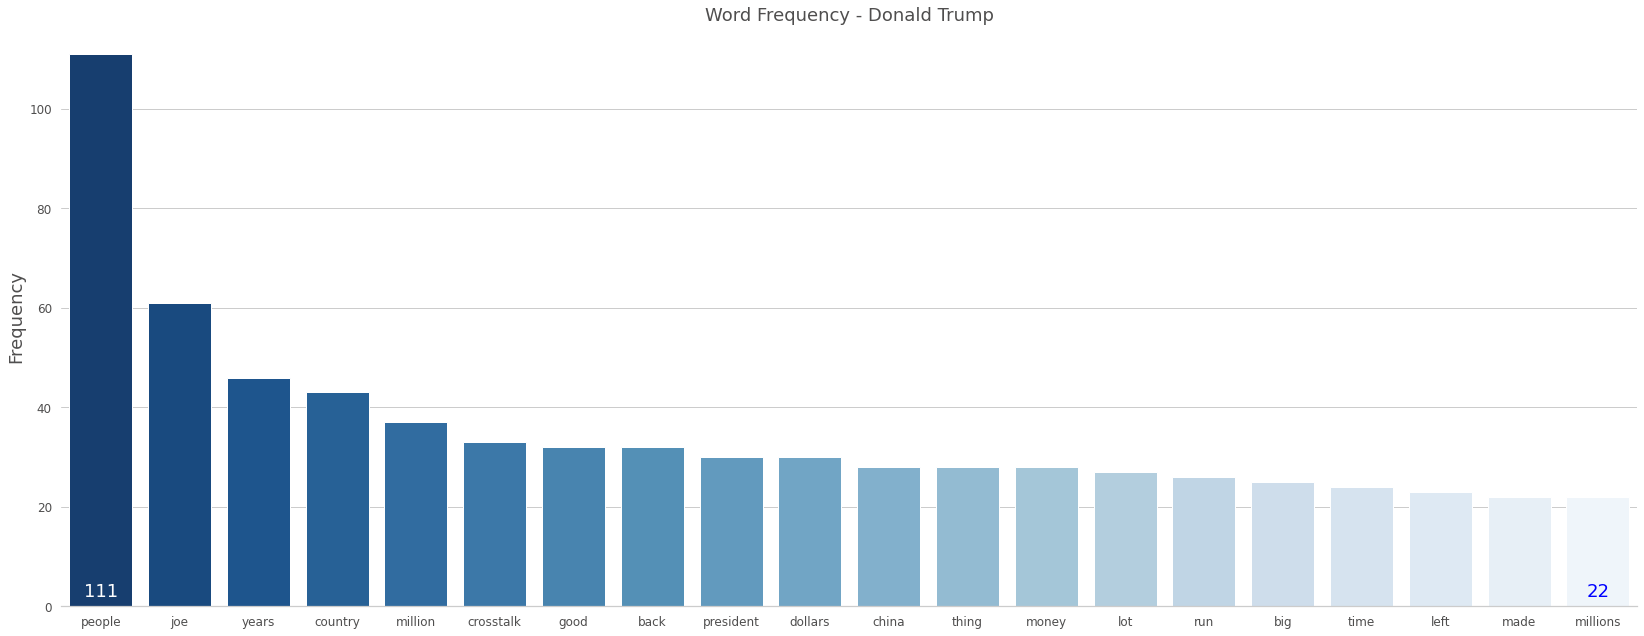

In [98]:
trump = text_cleaning('Donald Trump')
t = most_freq(trump)
trump_freq = make_plot(t,'Donald Trump')
# trump_freq.figure.savefig('images/plots/trump_freq.jpg')

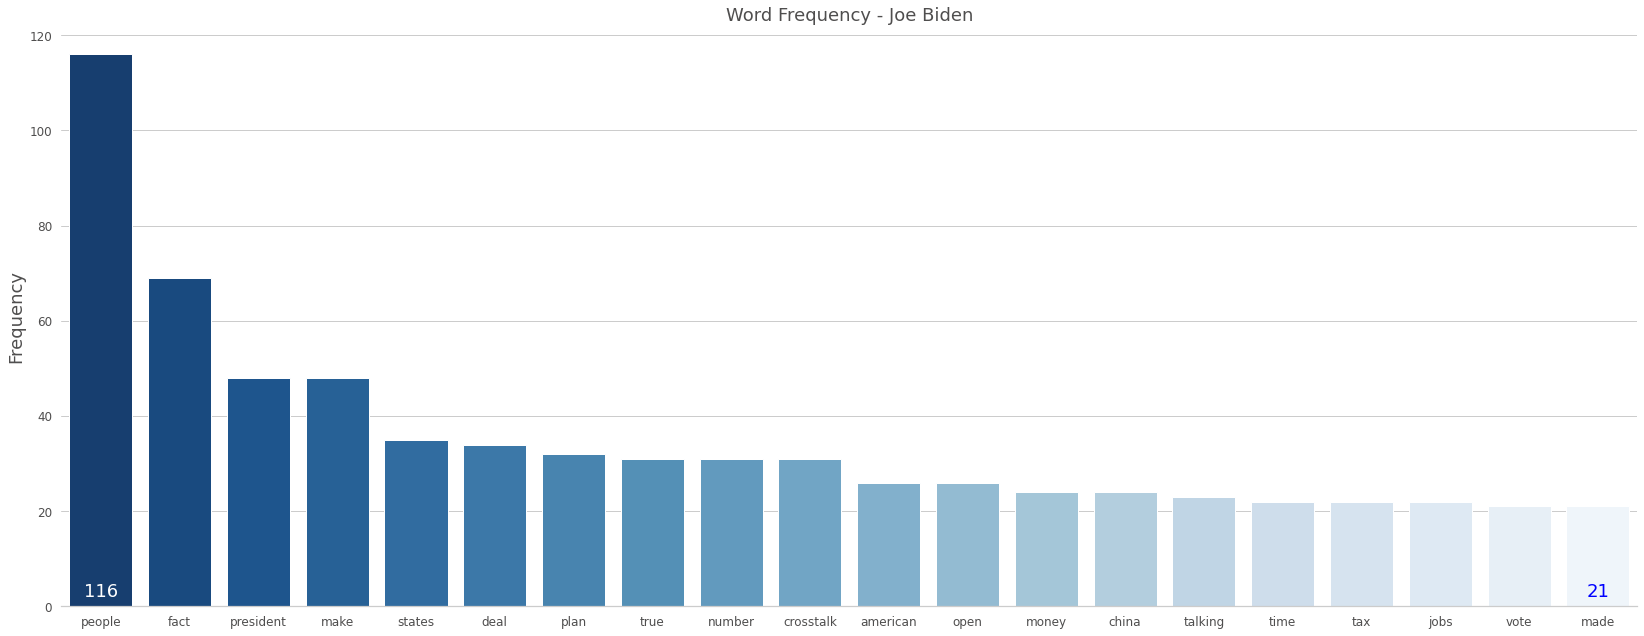

In [99]:
biden = text_cleaning('Joe Biden')
b = most_freq(biden)
biden_freq = make_plot(b,'Joe Biden')
# biden_freq.figure.savefig('images/plots/biden_freq.jpg')

In [102]:
df.loc[df['speaker'] == 'Chris Wallace','speaker'] = 'Moderator'
df.loc[df['speaker'] == 'Kristen Welker','speaker'] = 'Moderator'

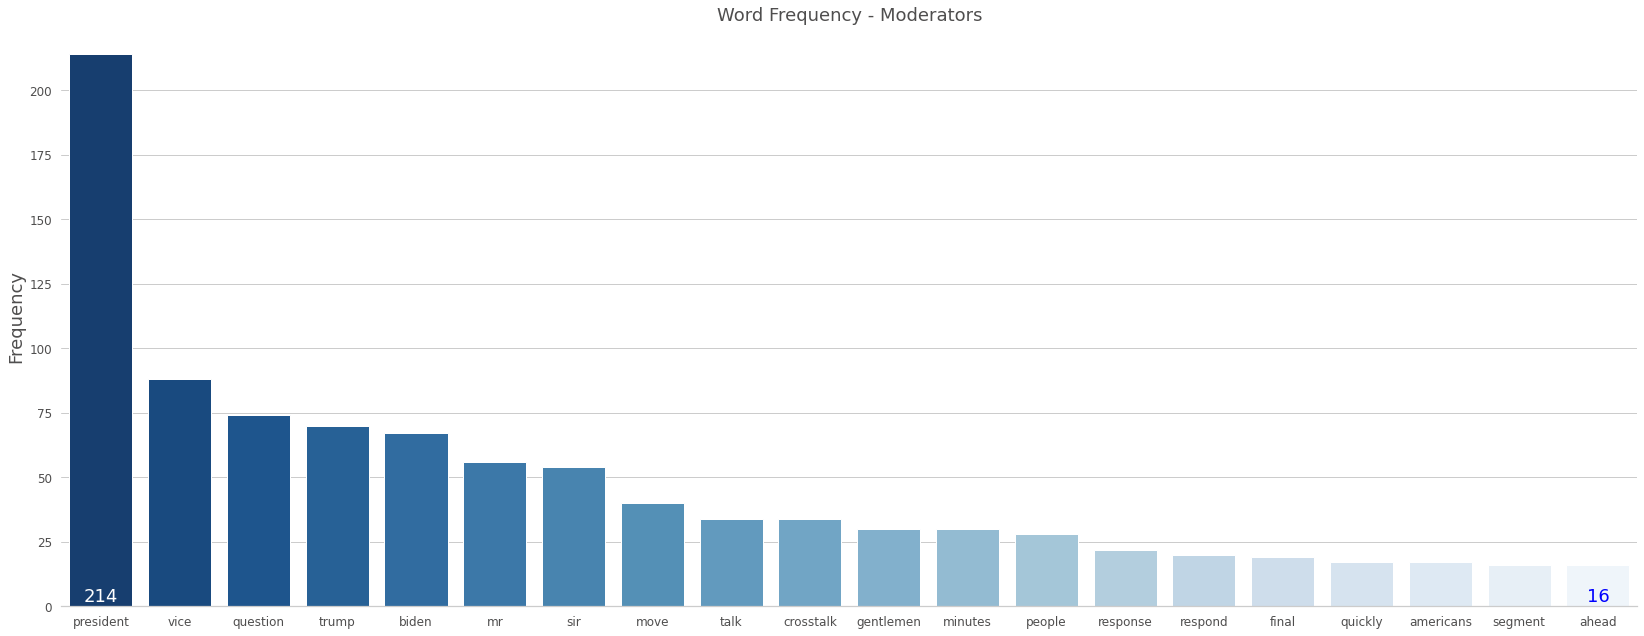

In [104]:
mod = text_cleaning('Moderator')
m = most_freq(mod)
mod_freq = make_plot(m,'Moderators')
# mod_freq.figure.savefig('images/plots/mod_freq.jpg')

In [105]:
def get_bigram(s,a):
    # Function to calculate frequent bigrams using nltk.tokenize. Setting length of words >=5 to ignore words such as 'hi','how','you',etc
    tokens = nltk.word_tokenize(s)
    eng_bigrams = nltk.bigrams(tokens)
    filtered_bigrams = [ (w1, w2) for w1, w2 in eng_bigrams if len(w1) >=5 and len(w2) >= 5 ]
    eng_bifreq = nltk.FreqDist(filtered_bigrams)
    return eng_bifreq.most_common(a)

In [106]:
trump_bg = get_bigram(trump,15)

In [107]:
biden_bg = get_bigram(biden,15)

In [108]:
def make_plot_bigrams(s,a):
    # Function to plot most frequent bigrams using Seaborn.
    s = dict(s)
    s_key = list(s.keys())
    s_val = list(s.values())
    m = []
    for x in range(0,len(s_key)):
        m.append(str(s_key[x][0]) + ' ' + str(s_key[x][1]))
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(15,12))
    x = sns.barplot(y=m, x=s_val, palette='Blues_r',orient='h');
    plt.title(f'Bigrams Frequency - {a}', size=18, color='#4f4e4e')
    plt.ylabel('Frequency', size=18, color='#4f4e4e');
    plt.xticks(size=12, color='#4f4e4e')
    plt.yticks(size=12, color='#4f4e4e')
    plt.text(x=0.5, y=0.1, s=s_val[0], color='white', fontsize=18, horizontalalignment='center')
    plt.text(x=0.5, y=14.1, s=s_val[14], color='blue', fontsize=18, horizontalalignment='center')
    sns.despine(left=True);
    return x

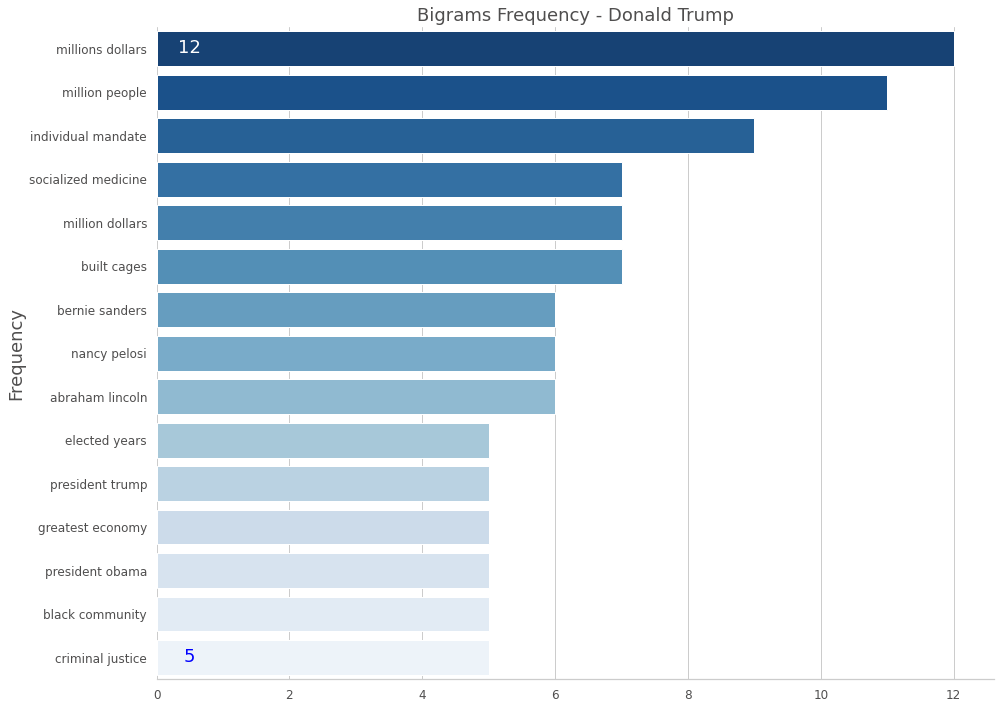

In [109]:
trump_bg = make_plot_bigrams(trump_bg, 'Donald Trump')
# trump_bg.figure.savefig('images/plots/trump_bg.jpg')

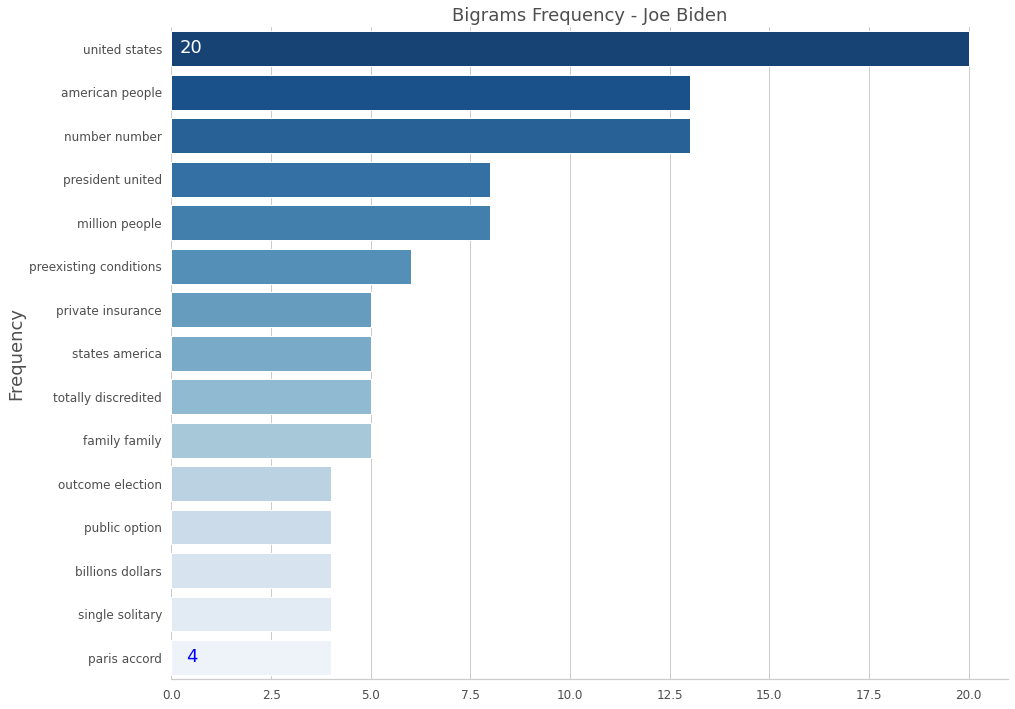

In [110]:
biden_bg = make_plot_bigrams(biden_bg, 'Joe Biden')
# biden_bg.figure.savefig('images/plots/biden_bg.jpg')

# Sentiment Analysis:

In [35]:
sid = SentimentIntensityAnalyzer()

In [36]:
df_candidate['compound_pol'] = [x.get('compound') for x in df_candidate['text'].apply(lambda x: sid.polarity_scores(x))] # getting the compound score. Ranges from -1(Negative) to +1(Positive)

In [37]:
def calc_sent(row):
    if row['compound_pol'] == 0:
        val = 'Neutral'
    elif row['compound_pol'] > 0:
        val = 'Positive'
    else:
        val = 'Negative'
    return val

In [38]:
df_candidate['sentiment'] = df_candidate.apply(lambda row : calc_sent(row), axis=1)

In [39]:
df_sent = df_candidate.groupby(['speaker','sentiment'],as_index=False).count()

In [40]:
df_sent['temp'] = df_sent['speaker'] + ' - ' + df_sent['sentiment']

In [41]:
df_sent = df_sent.loc[:,['temp','compound_pol']]

In [42]:
df_sent

,temp,compound_pol
0,Donald Trump - Negative,129
1,Donald Trump - Neutral,206
2,Donald Trump - Positive,169
3,Joe Biden - Negative,115
4,Joe Biden - Neutral,125
5,Joe Biden - Positive,142


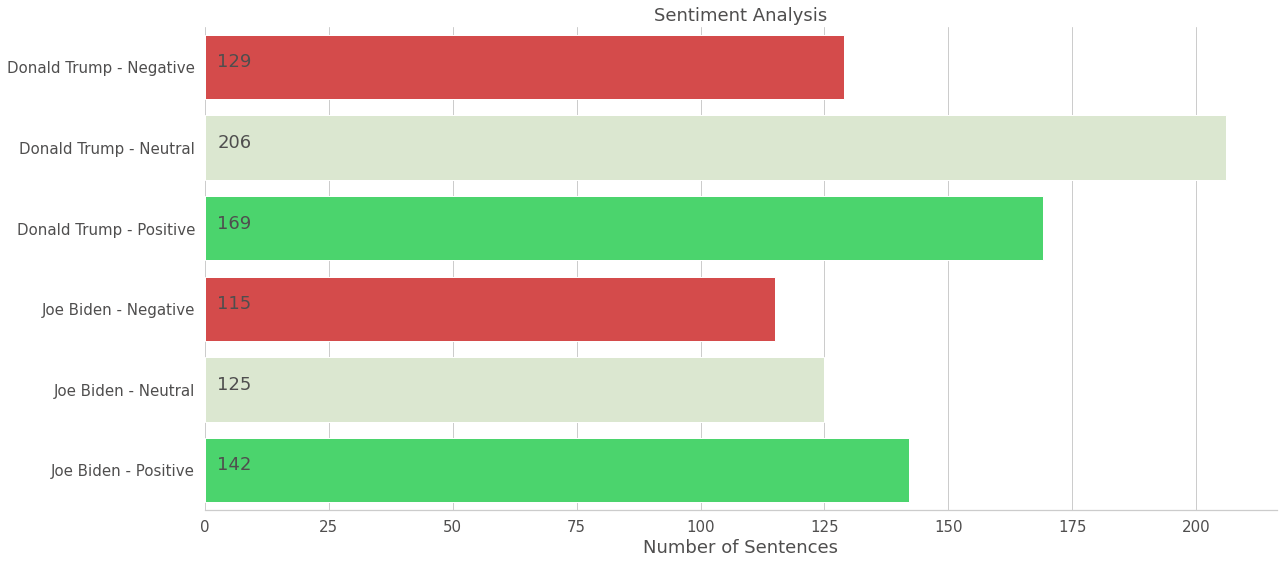

In [44]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(18,8))
sns.barplot(data=df_sent, y='temp', x='compound_pol',palette=['#eb3434','#dbebcc','#34eb62','#eb3434','#dbebcc','#34eb62'],orient='h'); 
plt.title('Sentiment Analysis', size=18, color='#4f4e4e')
plt.ylabel('');
plt.xlabel('Number of Sentences', size=18, color='#4f4e4e');
plt.xticks(size=15, color='#4f4e4e')
plt.yticks(size=15, color='#4f4e4e')
plt.text(x=6, y=0, s=129, color='#4f4e4e', fontsize=18, horizontalalignment='center')
plt.text(x=6, y=1, s=206, color='#4f4e4e', fontsize=18, horizontalalignment='center')
plt.text(x=6, y=2, s=169, color='#4f4e4e', fontsize=18, horizontalalignment='center')
plt.text(x=6, y=3, s=115, color='#4f4e4e', fontsize=18, horizontalalignment='center')
plt.text(x=6, y=4, s=125, color='#4f4e4e', fontsize=18, horizontalalignment='center')
plt.text(x=6, y=5, s=142, color='#4f4e4e', fontsize=18, horizontalalignment='center')
plt.tight_layout()
sns.despine(left=True);
plt.savefig('images/plots/sentiment.jpg')

In [123]:
def create_wordcloud(s):
    wordcloud = WordCloud(width = 1500, height = 800, background_color ='white', stopwords = stopwords,colormap='magma').generate(s)
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    return wordcloud

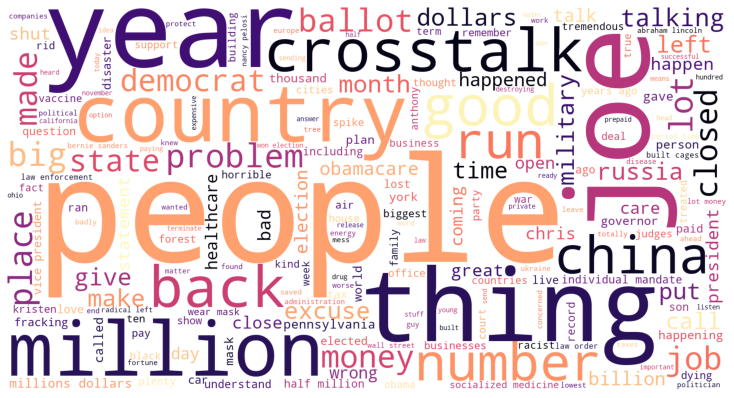

In [126]:
trump_wordc = create_wordcloud(trump)
# trump_wordc.to_file('images/plots/trump_wordc.jpg')

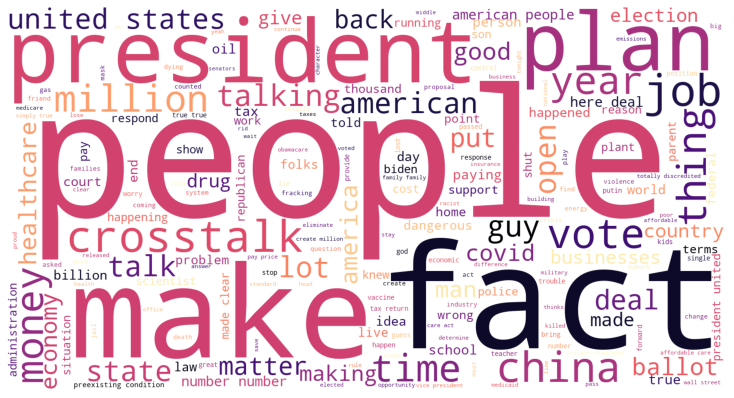

In [128]:
biden_wordc = create_wordcloud(biden)
# biden_wordc.to_file('images/plots/biden_wordc.jpg')